In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data
import models
from matplotlib_venn import venn3, venn2
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
import viz
from style import *
import analyze_helper
import train
from sklearn import decomposition
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA, KernelPCA

outcome_def = 'y_consec_thresh'
out_dir = oj('/scratch/users/vision/abc', 'mar6_1')
results = analyze_helper.load_results(out_dir)

df = data.get_data()
n = df.shape[0]
df = df[df['valid'] == 1] # exclude test cells, short/long tracks, hotspots
X, y, norms = analyze_helper.normalize(df, outcome_def)

# look at best models
r = results
r = r.sort_values('accuracy', ascending=False)
idx = np.array(r.index)
accs = np.array(r.accuracy)
model_name = idx[0]
# model_name = 'svm_16_ros=1.2_select_rf=3'
print('using model', model_name)
for i in range(5):
    print(f'\t{accs[i]:.3f}', idx[i])



d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df.cell_num, X, y)
y_full_cv = df[outcome_def].iloc[idxs_cv].values.astype(np.int)
preds = d_full_cv[model_name].values
preds_proba = d_full_cv[model_name + '_proba'].values

results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
assert np.sum(idxs_cv == np.arange(idxs_cv.size)) == idxs_cv.size, \
       'points not in same order'
assert np.mean(preds==y_full_cv) == np.average(results_individual['cv']['accuracy'], 
                                               weights=results_individual['num_pts_by_fold_cv']), \
        'did not properly load model/data'
tp, tn, fp, fn = analyze_helper.calc_errs(preds, y_full_cv)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
using model svm_25_select_rf=3_ros=0.8_h=0
	0.845 svm_25_select_rf=3_ros=0.8_h=0
	0.845 svm_25_select_rf=3_ros=0.8_h=-1
	0.844 svm_25_select_rf=3_ros=0.8_h=1
	0.839 svm_16_select_rf=3_ros=0.8_h=1
	0.839 svm_28_select_rf=3_ros=0.8_h=0


# look at single model

### visualize errs

In [ ]:
# visualize the biggest errors
num_to_plot = 16

print('total pts', preds.shape[0])
# for idxs, name in zip([fp, fn, tp, tn], ['fp', 'fn', 'tp', 'tn']):
# for idxs, name in zip([fp, fn], ['fp', 'fn']):
for idxs, name in zip([tp, tn], ['tp', 'tn']):
    print(name, idxs.sum(), idxs.sum() / preds.shape[0])
    inds = viz.viz_biggest_errs(df, idxs_cv, idxs, y_full_cv, preds, preds_proba, num_to_plot)
#     plt.savefig(f'{name}.pdf')
    plt.show()

In [ ]:
# visualize errs 1d
key = 'X_max' # lifetime, X_min, fall, X_max
viz.viz_errs_1d(X.iloc[idxs_cv], preds, preds_proba, y_full_cv, norms, key=key)

In [ ]:
# visualize errs 2d
key1 = 'fall' # fall, x_pos, pc1
key2 = 'X_mean' # X_min, y_pos, pc2
viz.viz_errs_2d(df, idxs_cv, preds, y_full_cv, key1=key1, key2=key2)
plt.xscale('log')
plt.yscale('log')

In [ ]:
# histogram of when things are peaking based on errs
dist_to_end = df.iloc[idxs_fp]['lifetime'] - df.iloc[idxs_fp]['Y_peak_idx'] - 1
frac_to_end = 1 - df.iloc[idxs_fp]['Y_peak_idx'] / df.iloc[idxs_fp]['lifetime']
print(np.unique(dist_to_end, return_counts=True))
plt.hist(frac_to_end, bins=100)
plt.show()

### calculate accs

In [196]:
# calculate acc for hotspots
results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
df = data.get_data(use_processed=False, remove_hotspots=False, save_processed=False)
df = df[df['hotspots']==1]
X, y, norms = normalize(df)

preds, pred_proba = analyze_helper.analyze_individual_results(results_individual, 
                                               X, y, print_results=False, 
                                               plot_results=False, model_cv_fold=1)
print(f'hotspots acc:\t\t\t{np.mean(preds==df[outcome_def])}')

loading + preprocessing data...
	loading tracks...
	preprocessing data...
	adding features...
hotspots acc:			0.6995884773662552


In [33]:
print('accuracy across cells', np.array(results_individual['cv']['accuracy']).round(2))

inter-cell accs [0.71 0.73 0.69 0.69 0.69]


### viz feature relationships

In [ ]:
# joint histograms of two features (colored by outcome)
viz.jointplot_grouped('fall', 'slope_end', 'y_consec_sig', df, scatter_alpha=0.1)

In [ ]:
# joint histogram, colored by predicted prob
print(results_individual['feat_names_selected'])
d = df.iloc[idxs_cv]
d['preds'] = preds
d['preds_proba'] = preds_proba
key1 = 'fall'
key2 = 'slope_end'
plt.figure(dpi=300)
plt.scatter(d[key1], d[key2], c=d['preds_proba'], alpha=0.5)
plt.xlabel(key1)
plt.ylabel(key2)
cb = plt.colorbar()
cb.set_label('predicted prob.')

### viz boundaries / outliers

In [ ]:
# m = results_individual['imps']['model'][0]    
# viz.plot_decision_boundary('X_std', 'fall', m, df, norms, num_pts=df.shape[0])

In [ ]:
# visualize outliers in venn-diagram
viz.viz_errs_outliers_venn(X.iloc[idxs_cv], preds, y_full_cv, num_feats_reduced=5)

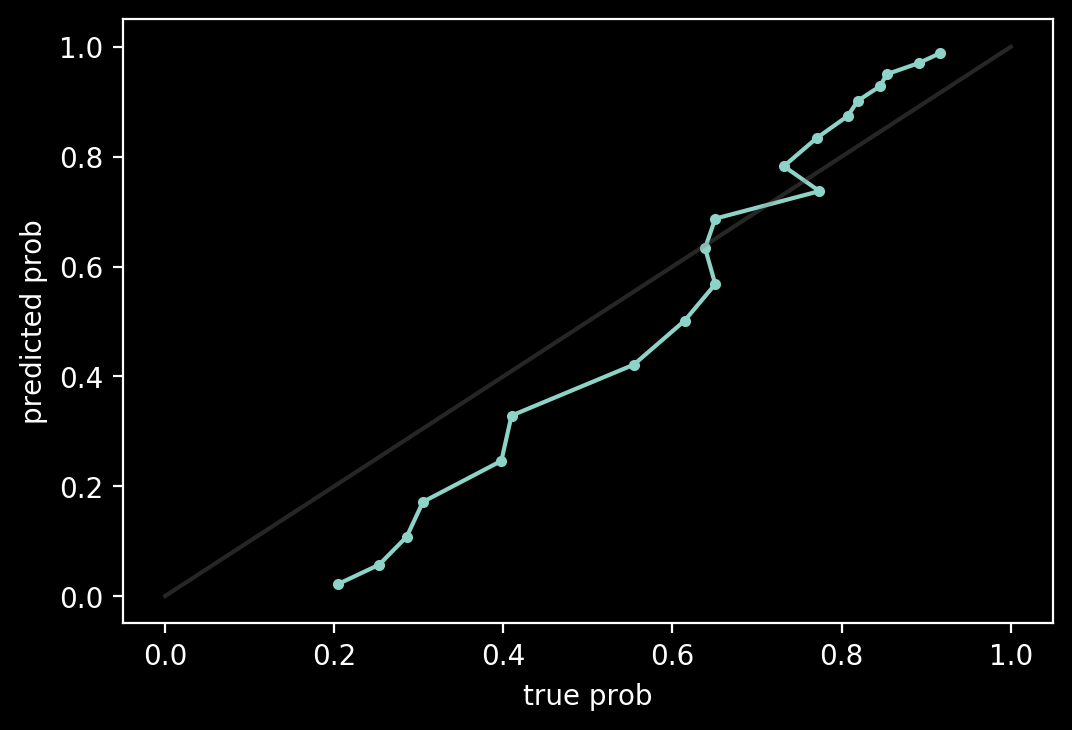

In [24]:
# calibration curve
plt.figure(dpi=200)
prob_true, prob_pred = calibration_curve(y_full_cv, preds_proba, 
                                         normalize=False, n_bins=20, strategy='quantile')
plt.plot(prob_true, prob_pred, '.-')
plt.plot([0, 1], [0, 1], alpha=0.3, color='gray')
plt.xlabel('true prob')
plt.ylabel('predicted prob')
plt.show()

(1661,) (1661,)


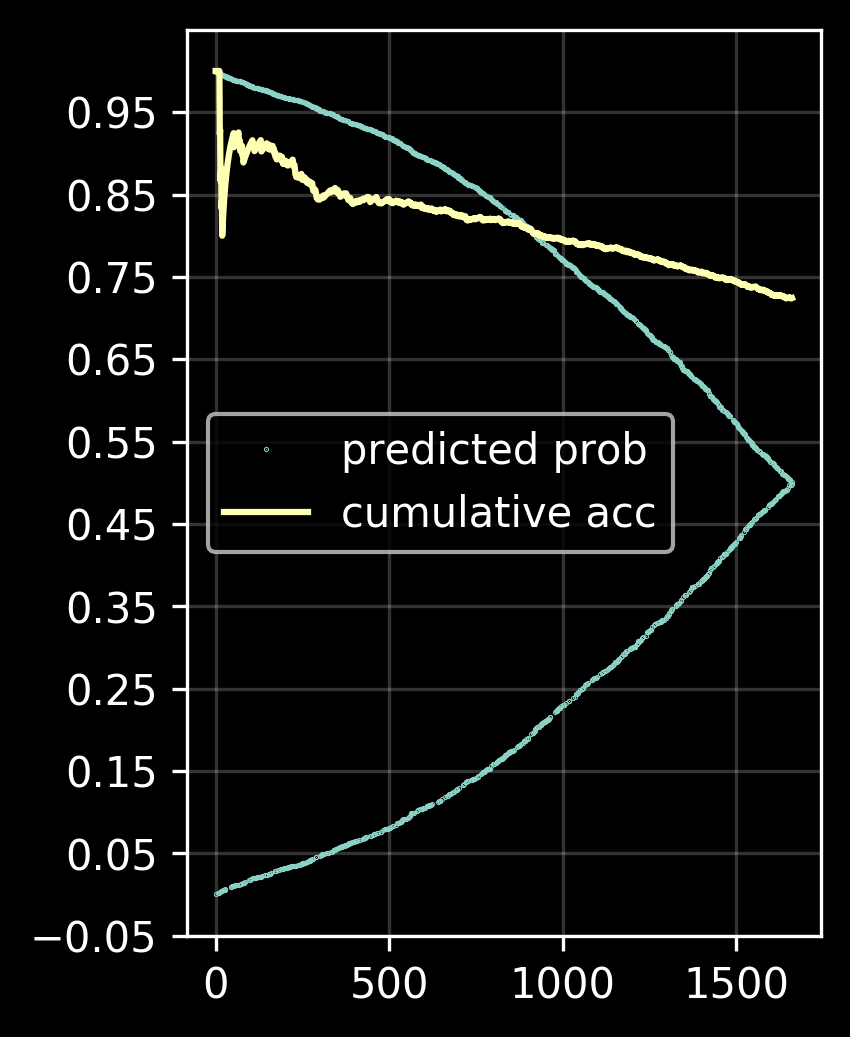

In [39]:
args = np.argsort(np.abs(preds_proba - 0.5))[::-1]
accs = (preds == y_full_cv)[args]
n = accs.size
accs = np.cumsum(accs) / np.arange(1, n + 1)
print(accs.shape, args.shape)

R, C = 1, 2

plt.figure(dpi=300)
plt.subplot(R, C, 1)
plt.plot(preds_proba[args], '.', ms=0.5, label='predicted prob')
plt.plot(accs, label='cumulative acc')
plt.yticks(np.arange(-0.05, 1.05, 0.1))
plt.grid(alpha=0.2)
plt.legend()

plt.subplot(R, C, 2)

plt.show()

In [31]:
accs

array([1.        , 1.        , 1.        , ..., 0.72393008, 0.72409639,
       0.72426249])

### look at pcs

In [ ]:
# perform pca
pca = decomposition.PCA(whiten=True)
pca.fit(X.iloc[idxs_cv])
viz.plot_pcs(pca, X.iloc[idxs_cv])

In [ ]:
pca = decomposition.PCA(n_components=2, whiten=True)
X_reduced = pca.fit_transform(X.iloc[idxs_cv])
plt.figure(dpi=200)
ys_neg = y[idxs_cv] == 0
plt.plot(X_reduced[:, 0][ys_neg], X_reduced[:, 1][ys_neg], 'o', 
         color=cr, alpha=0.3, markeredgewidth=0, ms=2)
plt.plot(X_reduced[:, 0][~ys_neg], X_reduced[:, 1][~ys_neg], 'o', 
         color=cb, alpha=0.3, markeredgewidth=0, ms=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
Y_feat_names = ['X_max',
                #'y_consec_sig', 
                'y_conservative_thresh', 
                'Y_peak_time_frac',
                'Y_max',
                'y_z_score',
                'X_max_diff'
                ]
pca = PCA(n_components=2)
df_train = df[df.cell_num.isin([1, 2, 3, 4, 5])]
df_train['y_cv'] = preds
df_no_consec = df_train[df_train.y_consec_sig == False]
df_X = df_no_consec[Y_feat_names]
df_X = (df_X - df_X.mean()) / df_X.std()
#X_new = X_new[np.where(df.y_consec_sig == False)[0],:]
X_new = pca.fit_transform(df_X)
#fig, ax = plt.subplots()
tn = np.where((df_no_consec[outcome_def] == 0) & (df_no_consec['y_cv'] == 0))[0]
tp = np.where((df_no_consec[outcome_def] == 1) & (df_no_consec['y_cv'] == 1))[0]
fn = np.where((df_no_consec[outcome_def] == 1) & (df_no_consec['y_cv'] == 0))[0]
fp = np.where((df_no_consec[outcome_def] == 0) & (df_no_consec['y_cv'] == 1))[0]

# look at many models

In [201]:
# model_names = ['mlp2_11_none', 'svm_35_none', 'logistic_4_none', 'rf_9_none']
# model_names = ['mlp2_11_none', 'mlp2_9_none', 'mlp2_4_none']
model_names = idx[:3]
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_names, out_dir, df.cell_num, X, y)
y_full_cv = df[outcome_def].iloc[idxs_cv].values

### ensemble err

In [202]:
# ensemble
d_full_cv_probs = d_full_cv[[k for k in d_full_cv.keys() if 'proba' in k]]
preds_soft = d_full_cv_probs.sum(axis=1) / d_full_cv_probs.shape[1]

for score_name in train.scorers.keys():
    print(score_name, train.scorers[score_name](y_full_cv, preds_soft > 0.5))
# metrics.accuracy_score(y_ensemble, preds_soft>0.5) 

balanced_accuracy 0.7042086967746695
accuracy 0.7206502107164359
precision 0.7748538011695907
recall 0.7733463035019456
f1 0.7740993184031157
roc_auc 0.7042086967746695
precision_recall_curve (array([0.61890427, 0.7748538 , 1.        ]), array([1.       , 0.7733463, 0.       ]), array([False,  True]))
roc_curve (array([0.        , 0.36492891, 1.        ]), array([0.       , 0.7733463, 1.       ]), array([2, 1, 0]))


**venn-diagram**

In [ ]:
sets = []
for model_name in model_names:
    args = np.argwhere(d_full_cv[model_name] != y_full_cv)
    sets.append(set(args.flatten().tolist()))
    
plt.figure(dpi=300)
plt.title('venn diagram of shared errors')
venn3(sets, model_names[:3])
plt.show()

# look at test data

In [11]:
df = data.get_data()
n = df.shape[0]
X, y, norms = analyze_helper.normalize(df, outcome_def)
idxs_test = df.cell_num.isin([data.cell_nums_test])
X_test, Y_test = X[idxs_test], y[idxs_test]